# Recipe Site Traffic Analysis Report


## About Company

Tasty Bytes was founded in 2020 in the midst of the Covid Pandemic. The world wanted
inspiration so we decided to provide it. We started life as a search engine for recipes, helping
people to find ways to use up the limited supplies they had at home.

Now, over two years on, we are a fully fledged business. For a monthly subscription we will put
together a full meal plan to ensure you and your family are getting a healthy, balanced diet
whatever your budget. Subscribe to our premium plan and we will also deliver the ingredients
to your door.

## Problem

I am responsible for choosing which recipes to display on the
homepage each day. At the moment, I choose my favorite recipe from a selection and display that on the home
page. 

We have noticed that traffic to the rest of the website goes up by as much as 40% if I
pick a popular recipe. But I don’t know how to decide if a recipe will be popular. More traffic
means more subscriptions so this is really important to the company.

## Request

- Predict which recipes will lead to high traffic.
- Correctly predict high traffic recipes 80% of the time.
- Provide business with recommendations what they do next.

## Contents
1. Data validation
2. Exploratory Analysis
3. Model Development and Evaluation
4. Definition of a metric for the business to monitor
5. Final summary & recommendations 



In [1616]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

In [1617]:
sns.set_style("whitegrid") 

In [1677]:
df = pd.read_csv('recipe_site_traffic_2212.csv', index_col=0)

In [1678]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [1620]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    object 
 6   high_traffic  574 non-null    object 
dtypes: float64(4), object(3)
memory usage: 59.2+ KB


In [1621]:
df.describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


First glance at the data and descriptive statistics let us make some conclusios:
- some column types are not appropriate;
- numerical columns apparently are right skewed;
- we should work with outliers in numerical columns, in particular large values;
- there are missing values in several columns, we'll work on them;
- high traffic column has no mark for ordinar traffic, that is why we observe large amount of NA in it.

#### Data types validation

According to the data scheme `index` column: 
>Numeric, unique identifier of recipe

In [1622]:
# Check if unique

len(df.index.unique()) == len(df)

True

According to the data scheme: 
- `calories`: Numeric, number of calories
- `carbohydrate`: Numeric, amount of carbohydrates in grams
- `sugar`: Numeric, amount of sugar in grams
- `protein`: Numeric, amount of protein in grams

From the previously obtained data overview all these columns have type float64. These columns data types are valid.

According to the data scheme `servings` column:
> Numeric, number of servings for the recipe

In [1679]:
# Check servings column

print(df['servings'].dtype)
df['servings'].value_counts()

object


servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

In [1680]:
# Clear servings column

df['servings'] = df['servings'].str.replace(' as a snack', '').astype('int')

print(df['servings'].dtype)
df['servings'].value_counts()

int64


servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64

According to the data scheme `category` column:
> Character, type of recipe. Recipes are listed in one of ten
possible groupings (Lunch/Snacks', 'Beverages', 'Potato',
'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One
Dish Meal').

In [1681]:
# Check if categories match

valid_category_list = ['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 
                       'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal']
valid_category_list.sort()
print('Valid: ', valid_category_list, ':', len(valid_category_list), '\n')


df_category_list = list(df['category'].unique()) 
df_category_list.sort()
print('Real: ', df_category_list, ':', len(df_category_list))


Valid:  ['Beverages', 'Breakfast', 'Chicken', 'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable'] : 10 

Real:  ['Beverages', 'Breakfast', 'Chicken', 'Chicken Breast', 'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato', 'Vegetable'] : 11


There is one extra category in our data - 'Chicken Breast'. Let's combine it with the general 'Chicken' category. 

In [1682]:
df['category'] = df['category'].str.replace('Chicken Breast', 'Chicken')

# Final check
set(df['category'].unique()) ^ set(valid_category_list)

set()

Final column `high_traffic` according to the scheme:
> Character, if the traffic to the site was high when this recipe
was shown, this is marked with “High”.

In [1683]:
df['high_traffic'].value_counts(dropna=False)

high_traffic
High    574
NaN     373
Name: count, dtype: int64

At first sight, this column is valid. But NA values as is won't be convenient in further validation and cleaning process. Therefore we'll mark 'High' traffic as '1' and all the rest NA values as '0'.

In [1684]:
df['high_traffic'] = df['high_traffic'].str.replace('High', '1').fillna(0).astype(int)
df['high_traffic'].value_counts()

high_traffic
1    574
0    373
Name: count, dtype: int64

#### Clear NA

In [1685]:
df.isna().sum()

calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

In [1686]:
# Check the amount of observations with NA in all 'containing NA' columns

threshold = len(df) * 0.055

contain_na_columns = df[['calories', 'carbohydrate', 'sugar', 'protein']]
all_na_n = len(df[contain_na_columns.isna().sum(axis=1) == 4])
print(all_na_n)
all_na_n < threshold

52


True

The amount of rows containing NA in all 'containing NA' columns is equal (that means we have a deal with the same rows) and is less than 5.5% of the data. It allows us to remove these observations.

In [1687]:
df = df.dropna() 

In [1688]:
df.isna().sum()

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

#### Outliers

In [1689]:
df.describe()

,calories,carbohydrate,sugar,protein,servings,high_traffic
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296,3.458101,0.597765
std,453.020997,43.949032,14.679176,36.369739,1.735979,0.490623
min,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,110.430000,8.375000,1.690000,3.195000,2.000000,0.000000
50%,288.550000,21.480000,4.550000,10.800000,4.000000,1.000000
75%,597.650000,44.965000,9.800000,30.200000,4.000000,1.000000
max,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


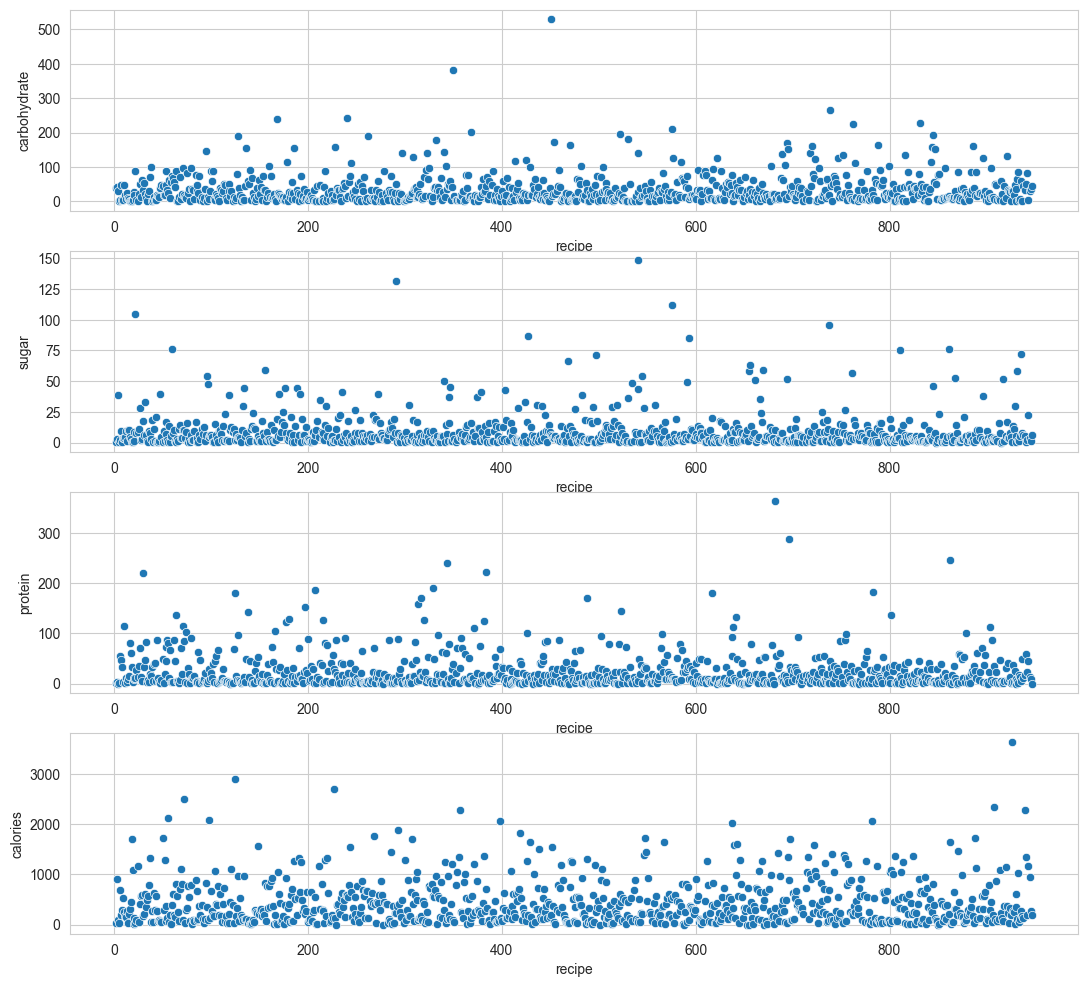

In [1690]:
fig, ax = plt.subplots(4, 1, figsize = (13,12))
sns.scatterplot(x=df.index, y=df['carbohydrate'], ax=ax[0])
sns.scatterplot(x=df.index, y=df['sugar'], ax=ax[1])
sns.scatterplot(x=df.index, y=df['protein'], ax=ax[2])
sns.scatterplot(x=df.index, y=df['calories'], ax=ax[3])
plt.show()

We observe only a few extremely high values in every variable, at the same time we could trust low observations. That is why we can't apply here a standard technique with 25th and 75th quantiles and IQR * 1.5. We should be extremely accurate, that is why we'll widen our IQR to 90% of data.

In [1691]:
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:

    col_iqr = df[col].quantile(0.95) - df[col].quantile(0.05)

    upper = df[col].quantile(0.95) + (col_iqr * 1.5)
    lower = df[col].quantile(0.05) - (col_iqr * 1.5)

    df = df[(df[col] < upper) & (df[col] > lower)] 

In [1692]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
2,35.48,38.56,0.66,0.92,Potato,4,1
3,914.28,42.68,3.09,2.88,Breakfast,1,0
4,97.03,30.56,38.63,0.02,Beverages,4,1
5,27.05,1.85,0.80,0.53,Beverages,4,0
6,691.15,3.46,1.65,53.93,One Dish Meal,2,1


### Exploratory Analysis

In [1636]:
# Numeric variables. All are right skewed, as expected. Low values are dominating.

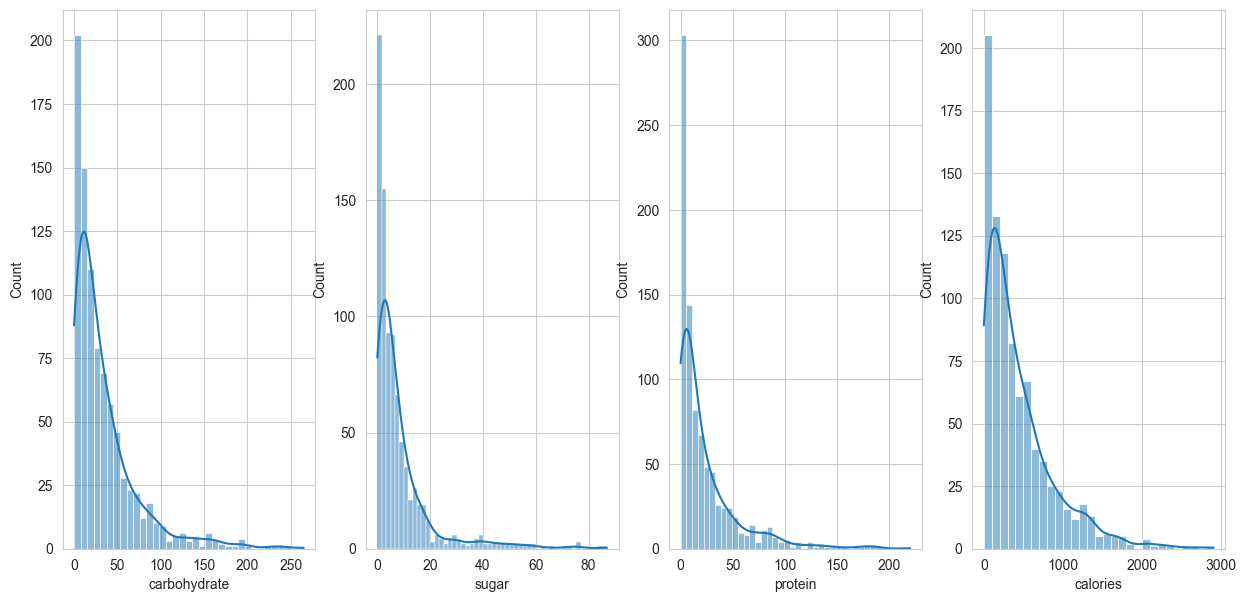

In [1675]:
fig, ax = plt.subplots(1, 4, figsize = (15,7))
sns.histplot(df['carbohydrate'], kde=True, ax=ax[0])
sns.histplot(df['sugar'], kde=True, ax=ax[1])
sns.histplot(df['protein'], kde=True, ax=ax[2])
sns.histplot(df['calories'], kde=True, ax=ax[3])
plt.show()

In [1638]:
# Outliers are not so obvious now. 

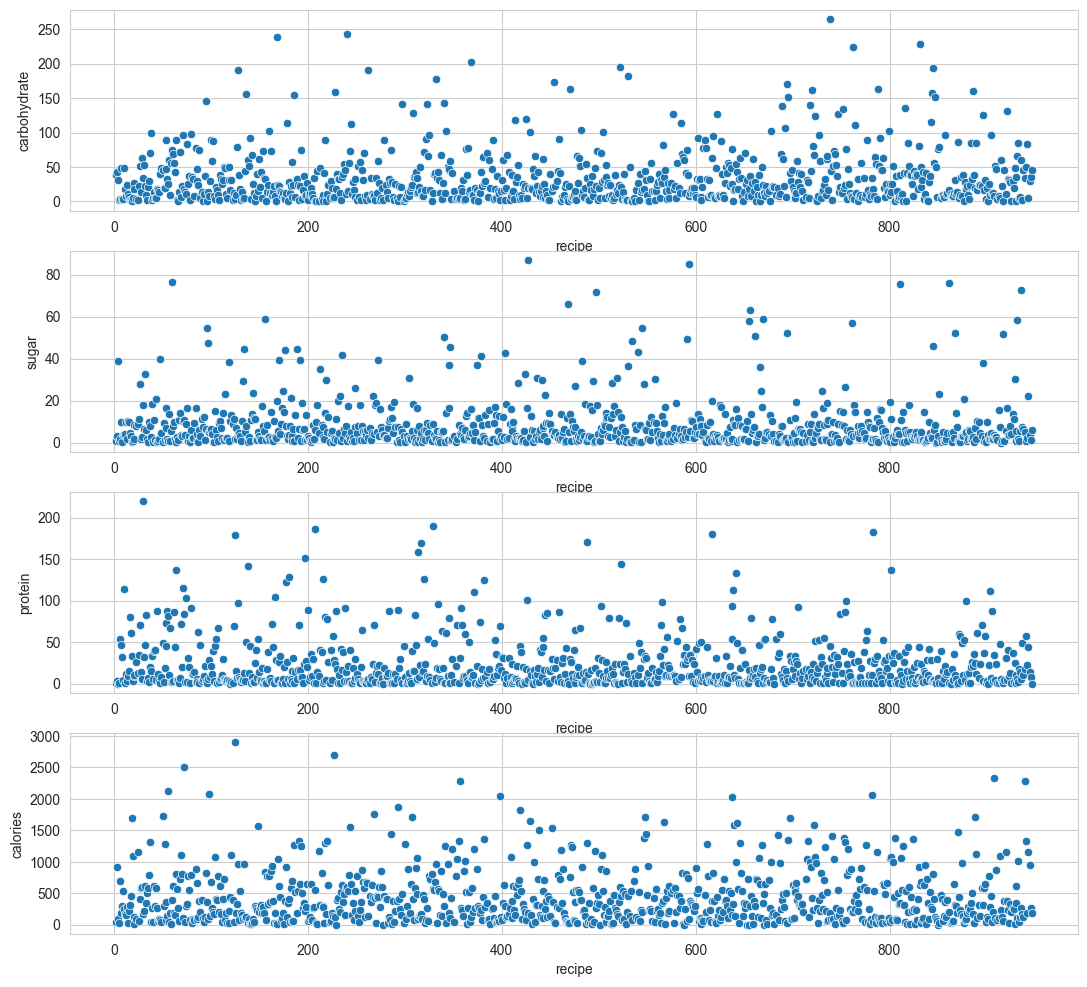

In [1639]:
fig, ax = plt.subplots(4, 1, figsize = (13,12))
sns.scatterplot(x=df.index, y=df['carbohydrate'], ax=ax[0])
sns.scatterplot(x=df.index, y=df['sugar'], ax=ax[1])
sns.scatterplot(x=df.index, y=df['protein'], ax=ax[2])
sns.scatterplot(x=df.index, y=df['calories'], ax=ax[3])
plt.show()

In [1640]:
# Categorical variables

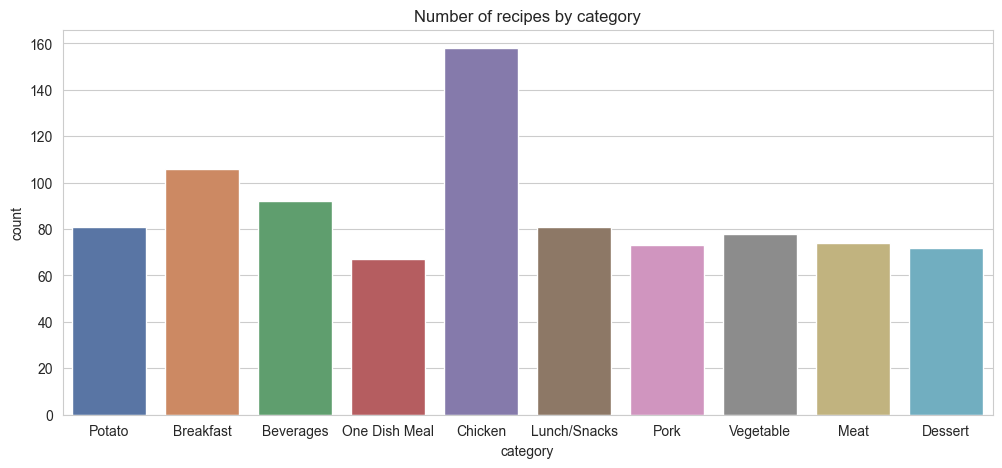

In [1641]:
fig, ax = plt.subplots(figsize = (12,5))
sns.countplot(df, x='category', hue='category', palette='deep')
ax.set_title('Number of recipes by category')
plt.show()

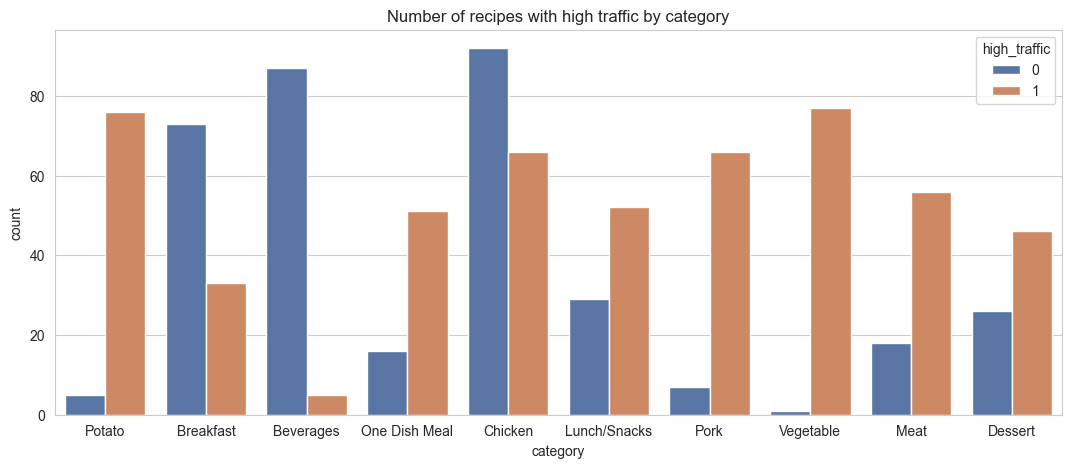

In [1642]:
fig, ax = plt.subplots(figsize = (13,5))
sns.countplot(df, x='category', hue='high_traffic', palette='deep')
ax.set_title('Number of recipes with high traffic by category')
plt.show()

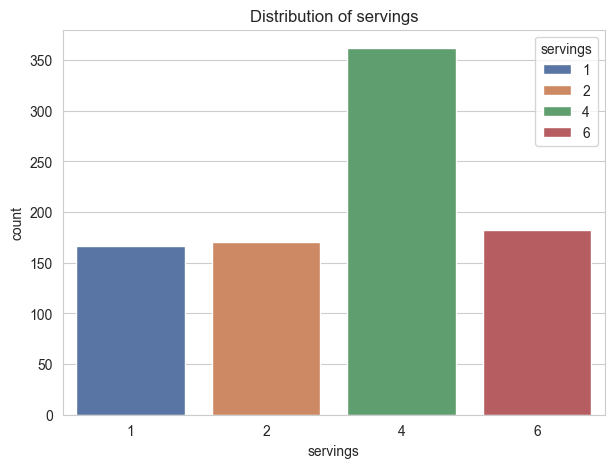

In [1643]:
fig, ax = plt.subplots(figsize = (7,5))
sns.countplot(df, x='servings', hue='servings', palette='deep')
ax.set_title('Distribution of servings')
plt.show()

From the plots above:
- The largest number of recipes are observed in `Chicken` category. `Breakfast` and `Beverages` are also noticeable in this case.
- Some insights gives us the comparison of high and ordinar traffic per category. It turns out to be that `Chicken` category being the most numbered doesn't lead to high traffic more often. `Breakfast` and `Beverages` the same and even worser. Instead `Potato`, `Pork` and `Vegetable` are likely to cause traffic raise.
- Typically recipes are presented in 4 servings.

In [ ]:
# Correlations

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


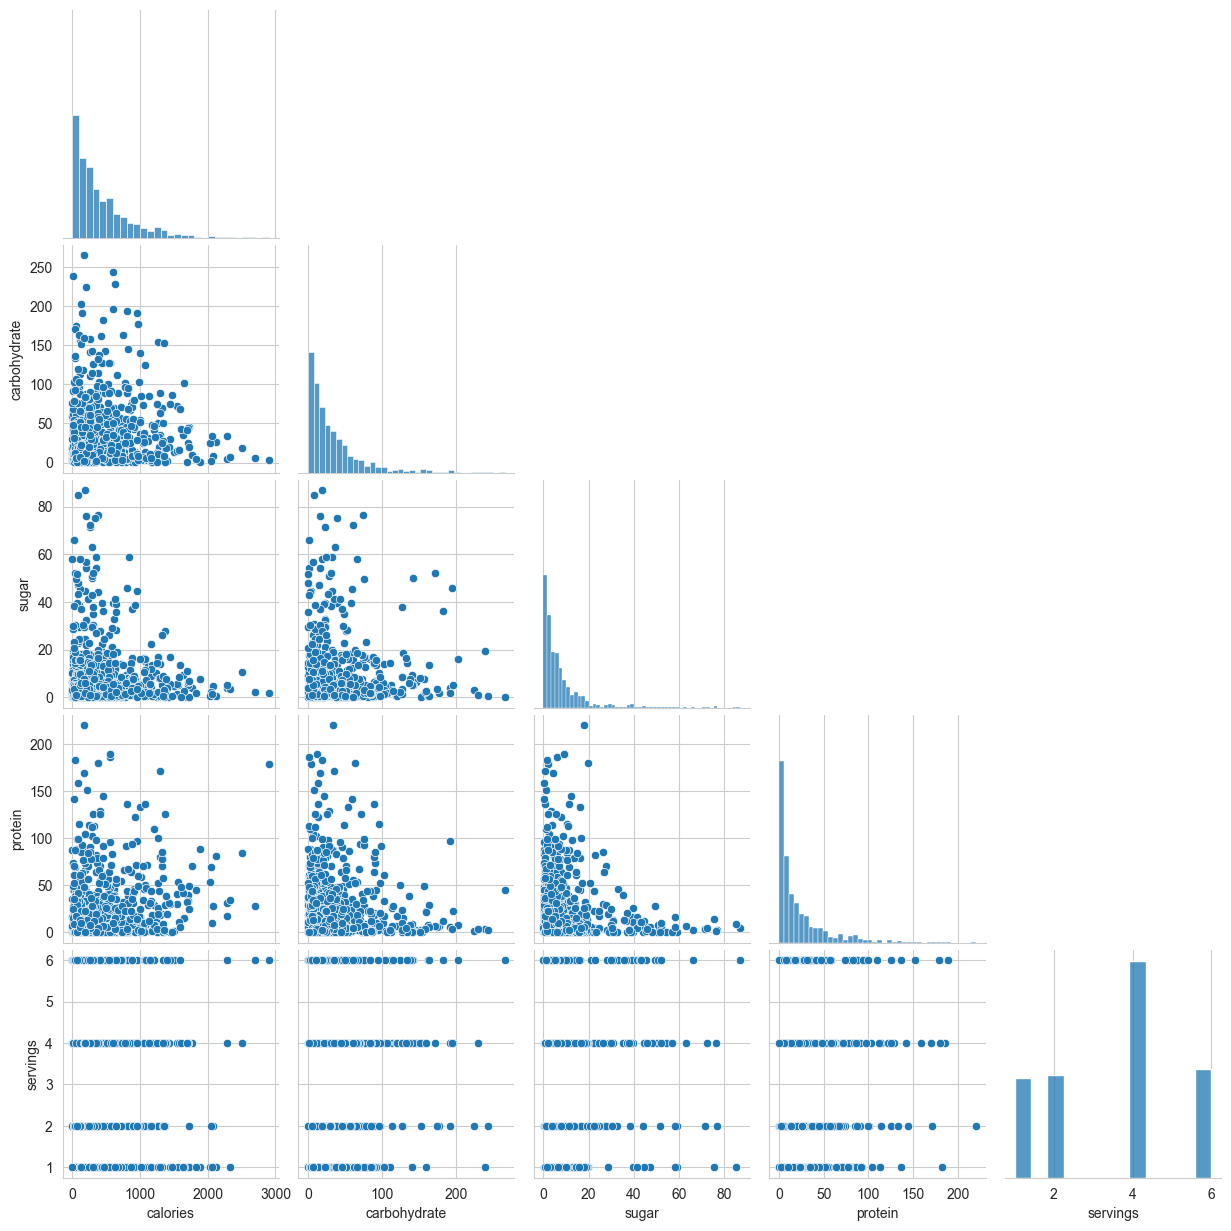

In [1644]:
sns.pairplot(data=df, vars=['calories', 'carbohydrate', 'sugar', 'protein', 'servings'], corner=True)
plt.show()

In [1645]:
df.drop(['category','high_traffic'], axis=1).corr()

,calories,carbohydrate,sugar,protein,servings
calories,1.000000,-0.006591,-0.089329,0.186073,-0.046306
carbohydrate,-0.006591,1.000000,0.014495,-0.033734,-0.006345
sugar,-0.089329,0.014495,1.000000,-0.104104,0.009295
protein,0.186073,-0.033734,-0.104104,1.000000,-0.046772
servings,-0.046306,-0.006345,0.009295,-0.046772,1.000000


Correlation analysis shows us that we don't have any significant correlations between variables. 

In [ ]:
# Aggregations

In [1646]:
df_cat_agg = df.groupby('category').agg(np.median)
df_cat_agg

,calories,carbohydrate,sugar,protein,servings,high_traffic
category,,,,,,
Beverages,126.455,11.250,8.075,0.410,4.0,0.0
Breakfast,229.380,28.420,4.830,11.685,4.0,0.0
Chicken,371.905,15.520,3.400,33.050,4.0,0.0
Dessert,290.375,35.620,22.090,4.715,4.0,1.0
Lunch/Snacks,370.920,31.760,2.680,11.970,4.0,1.0
Meat,460.870,19.115,3.385,28.530,4.0,1.0
One Dish Meal,419.280,25.430,4.040,28.480,2.0,1.0
Pork,399.260,19.560,5.230,29.820,4.0,1.0
Potato,274.630,31.360,2.480,5.900,4.0,1.0


The meal category explains its number of calories, amount of carbohydrates, sugar, and protein. There is no reason to visualize it. Let's look again at high traffic per category from another perspective.

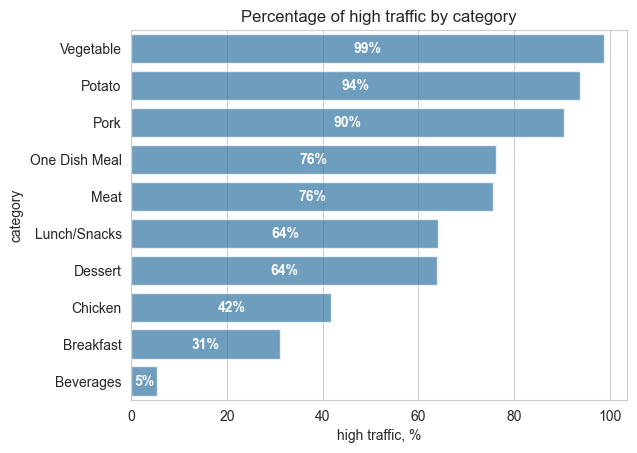

In [1647]:
df_cat_group = df.groupby('category')['high_traffic'].agg(['sum', 'count'])
df_cat_group['perc'] = (df_cat_group['sum'] / df_cat_group['count']) * 100
df_cat_group.sort_values(by='perc',ascending = False, inplace=True)

ax = sns.barplot(x = 'perc', y = 'category' , data = df_cat_group, alpha=0.7)

for index, row in df_cat_group.iterrows():
    ax.text(x = (row.perc/2), y= index, s = f'{round(row.perc)}%', 
            color='white', weight='demi', ha='center', va='center')
    
ax.set_title('Percentage of high traffic by category')
ax.set_xlabel('high traffic, %')
plt.show()

Exploratory analysis conclusions:
- As expected, numerical variables are all right skewed. There still could be some outliers that seem uncritical.
- Despite being the most fulfilled `Chicken`, `Breakfast`, `Beverages`categories don't lead to high traffic. Instead `Potato`, `Pork` and `Vegetable` do.
- Explicit and significant correlations between variables are not observed.

### Model Development and Evaluation

As soon as the customer request is **to correctly predict high traffic recipes 80% of the time** we have a **classification problem**. At the same time, we should **minimize the chance of low recipe traffic**. Accordingly, our main evaluation metric (**KPI**) would be **precision**, that is the proportion of correctly predicted positive instances.
We will also take a look at *accuracy* (how correctly all events are predicted) and *sensitivity* (the ability to correctly identify positive cases), as they are closely standing to precision. 

The selected classification models for development and comparison are:
- **Logistic Regression** - baseline;
- **Decision Tree**.

Besides model development, we'll use cross-validation to find the best set of parameters for each classifier. We also will take a glance at *ROC curves*, which could help us to estimate model performances and make the final decisions.

#### Preprocess data for modeling

In [1648]:
seed = 62

In [1649]:
# Categorical to dummies

category_wide = pd.get_dummies(df['category'], dtype = 'int')
df = pd.concat((df, category_wide), axis=1).drop('category', axis=1)

In [1650]:
# Split dataset 

X = df.drop('high_traffic', axis=1).values
y = df['high_traffic'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

In [1651]:
# Scaling, as we have different feature scales

scaler = StandardScaler()

X_train[:,0:5] = scaler.fit_transform(X_train[:,0:5])
X_test[:,0:5] = scaler.transform(X_test[:,0:5])

In [1652]:
def get_scores(model, y_test, y_pred, y_pred_probs, custom_name='default'):
    scores = pd.DataFrame([{
        'model': model.__class__.__name__,
        'name': custom_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_probs)}])
    return scores

#### Logistic Regression

In [1653]:
# Logistic Regression

logreg = LogisticRegression(random_state=seed).fit(X_train, y_train)

log_y_pred = logreg.predict(X_test)
log_y_pred_probs = logreg.predict_proba(X_test)[:, 1]

logreg_score = get_scores(logreg, y_test, log_y_pred, log_y_pred_probs)
logreg_score

,model,name,accuracy,precision,recall,ROC AUC
0,LogisticRegression,default,0.785311,0.809091,0.839623,0.834839


In [1654]:
print(classification_report(y_test, log_y_pred))

              precision    recall  f1-score   support

           0       0.75      0.70      0.72        71
           1       0.81      0.84      0.82       106

    accuracy                           0.79       177
   macro avg       0.78      0.77      0.77       177
weighted avg       0.78      0.79      0.78       177



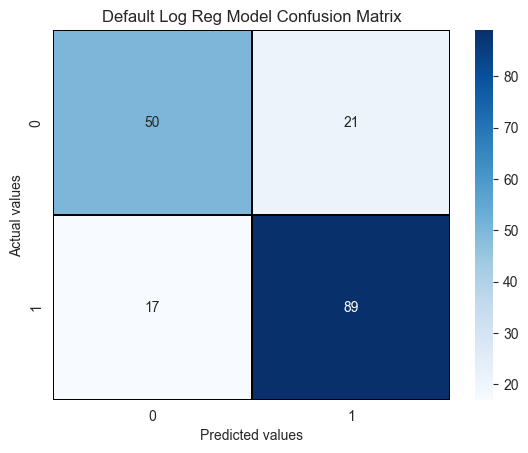

In [1655]:
# Logistic Regression confusion matrix 
conf_matrix=confusion_matrix(y_test, log_y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='Blues',linewidth=0.3,linecolor='black')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.title('Default Log Reg Model Confusion Matrix')
plt.show()

In [1656]:
# Logistic Regression Tuning | RandomizedSearchCV

params = {"solver": ["lbfgs", "liblinear"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1.0, 50)}

logreg_cv = RandomizedSearchCV(logreg, params, cv=5, scoring='precision')

logreg_cv.fit(X_train, y_train)
log_y_pred_cv = logreg_cv.predict(X_test)
log_y_pred_cv_probs = logreg_cv.predict_proba(X_test)[:, 1]

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}\n".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Best Precision Score: {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'tol': 0.8571571428571428, 'solver': 'liblinear', 'C': 0.7979591836734694}

Tuned Logistic Regression Best Precision Score: 0.7972777255032195


In [1657]:
tuned_logreg_score = get_scores(logreg_cv, y_test, log_y_pred_cv, log_y_pred_cv_probs, custom_name = 'LogReg')
tuned_logreg_score

,model,name,accuracy,precision,recall,ROC AUC
0,RandomizedSearchCV,LogReg,0.785311,0.809091,0.839623,0.830056


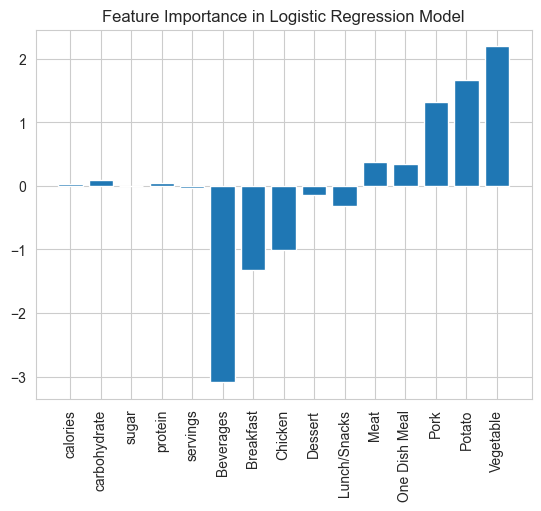

In [1659]:
resultdict = dict(zip(df.drop('high_traffic', axis=1).columns, logreg.coef_[0]))
    
plt.bar(resultdict.keys(), resultdict.values()) 
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Logistic Regression Model');

#### Decision Tree 

In [1660]:
# Decision Tree

dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train, y_train)

dt_y_pred = dt.predict(X_test)
dt_y_pred_probs = dt.predict_proba(X_test)[:, 1]

dt_score = get_scores(dt, y_test, dt_y_pred, dt_y_pred_probs)
dt_score

,model,name,accuracy,precision,recall,ROC AUC
0,DecisionTreeClassifier,default,0.632768,0.684685,0.716981,0.612012


In [1661]:
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

           0       0.55      0.51      0.53        71
           1       0.68      0.72      0.70       106

    accuracy                           0.63       177
   macro avg       0.62      0.61      0.61       177
weighted avg       0.63      0.63      0.63       177



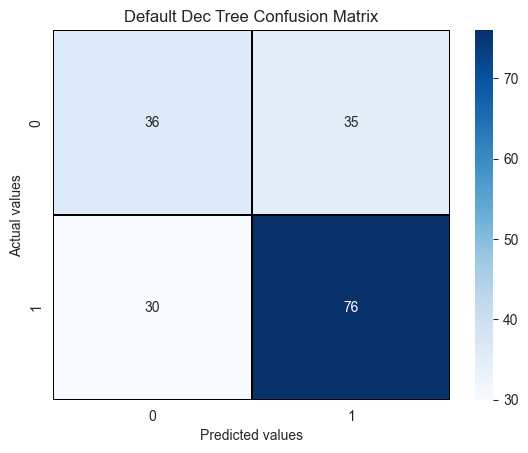

In [1662]:
# Decision Tree confusion matrix 

conf_matrix=confusion_matrix(y_test, dt_y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidth=0.3, linecolor='black')
plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.title('Default Dec Tree Confusion Matrix')
plt.show()

In [1663]:
# Decision Tree Tuning | GridSearchCV

dt_params= {'criterion': ['gini', 'entropy'],
            'max_depth': np.arange(3, 10),
            'min_samples_split': [2,3,4],
            'min_samples_leaf': [1,2,3],
            'ccp_alpha': np.arange(0, 0.6, 0.1)}

dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='precision')
dt_grid.fit(X_train, y_train)
dt_y_pred_grid = dt_grid.predict(X_test)
dt_y_pred_grid_probs = dt_grid.predict_proba(X_test)[:, 1]

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: \n{}\n".format(dt_grid.best_params_))
print("Tuned Decision Tree Best Precision Score: {}".format(dt_grid.best_score_))

Tuned Decision Tree Parameters: 
{'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

Tuned Decision Tree Best Precision Score: 0.7960199226745784


In [1664]:
tuned_dt_score = get_scores(dt_grid, y_test, dt_y_pred_grid, dt_y_pred_grid_probs, custom_name = 'DecisionTree')
tuned_dt_score

,model,name,accuracy,precision,recall,ROC AUC
0,GridSearchCV,DecisionTree,0.785311,0.809091,0.839623,0.789995


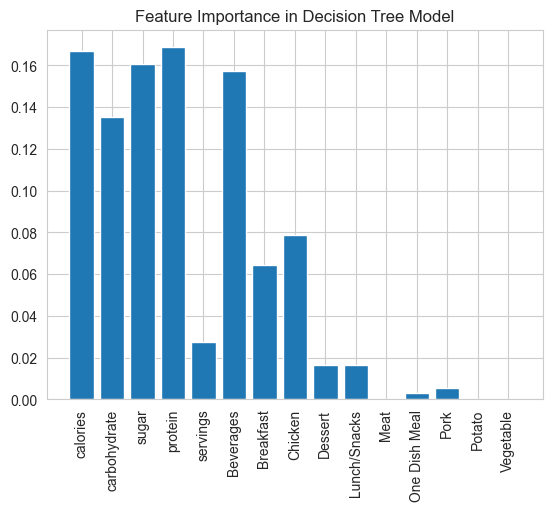

In [1665]:
resultdict = dict(zip(df.drop('high_traffic', axis=1).columns, np.abs(dt.feature_importances_)))
    
plt.bar(resultdict.keys(), resultdict.values()) #, figsize=(10, 5)
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Decision Tree Model');


In [1666]:
def get_auc(y_pred_probs):
    return roc_auc_score(y_test, y_pred_probs).round(2)

def get_roc_curve(y_pred_probs):
    return roc_curve(y_test, y_pred_probs)

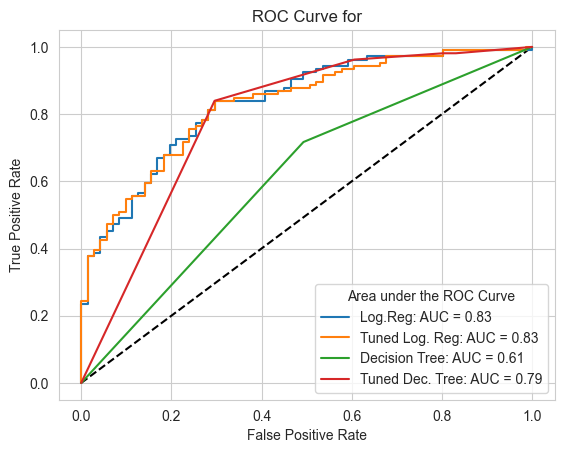

In [1667]:
# Compare ROC Curves

pred_probs_list = [log_y_pred_probs, dt_y_pred_probs, log_y_pred_cv_probs, dt_y_pred_grid_probs]

log_auc, dt_auc, tun_log_auc, tun_dt_auc = map(get_auc, pred_probs_list)

log_fpr, log_tpr, _ = get_roc_curve(log_y_pred_probs)
dt_fpr, dt_tpr, _ = get_roc_curve(dt_y_pred_probs)

tun_log_fpr, tun_log_tpr, _ = get_roc_curve(log_y_pred_cv_probs)
tun_dt_fpr, tun_dt_tpr, _ = get_roc_curve(dt_y_pred_grid_probs)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(log_fpr, log_tpr, label = f'Log.Reg: AUC = {log_auc}')
plt.plot(tun_log_fpr, tun_log_tpr, label = f'Tuned Log. Reg: AUC = {tun_log_auc}')

plt.plot(dt_fpr, dt_tpr, label = f'Decision Tree: AUC = {dt_auc}')
plt.plot(tun_dt_fpr, tun_dt_tpr, label = f'Tuned Dec. Tree: AUC = {tun_dt_auc}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for')
plt.legend(loc = 4, title = 'Area under the ROC Curve')
plt.show()

In [1668]:
# Compare scores

pd.concat([logreg_score, tuned_logreg_score, dt_score, tuned_dt_score]).set_index('model')

,name,accuracy,precision,recall,ROC AUC
model,,,,,
LogisticRegression,default,0.785311,0.809091,0.839623,0.834839
RandomizedSearchCV,LogReg,0.785311,0.809091,0.839623,0.830056
DecisionTreeClassifier,default,0.632768,0.684685,0.716981,0.612012
GridSearchCV,DecisionTree,0.785311,0.809091,0.839623,0.789995


#### Model Development and Evaluation results

Two classifier models were developed, tuned and evaluated. From the perspective of our KPI metric - precision, both models LogisticRegression and tuned DecisionTreeClassifier overcame the desired 80% threshold and scored the same way (~81%). To select the best model we should look at additional scores. LogisticRegression has a greater AUC score which means that this model performs better. 

Thus, the tuned **LogisticRegression model is recommended** for the recipe classification process and should be implemented on the customer website to increase traffic at least 80% of the time.

### Definition of a metric for the business to monitor

From a business perspective, predicting recipes that in reality lead to high traffic as those that lead to low traffic is a more significant error than vice versa. That is why, our focus is on model **precision**. Its high score allows us to avoid substantial losses for the business caused by inaccurate forecasts.
As our developed model in theory showed 81% presicion - we should monitor it in a wild and use it as initial value.

### Final summary & recommendations

Overall recommendations for the customer: 
- The provided analysis was based on the data with around 1000 observations. We recommend to collect more data to improve analytics and modeling processes.
- We recommend add more recipe features, such as time to make and cost per serving.
- During analysis were identified recipe categories that lead to high traffic: `Potato`, `Pork` and `Vegetable`. And categories which don't: `Chicken`, `Breakfast`, `Beverages`. At the same time `Chicken` category significantly dominates above others.

Technical recommendations:
1. Implement tuned Logistic Regression model for the recipe selection process onto website instead of current solution.
2. Define test period, collect data and provide A/B tests to measure new recipe selection process effect.
2. Monitor target metric and collect log data constantly to share with us next time.
